## Statistic-Focused Fitting
> Example driven review and analysis fo how fitting model to a specific selection of phenomena helps clarify model limitations. Useful for establishing that model can or cannot account for the considered effect in principle. But limited, even in aggregate, as measure of overall performance.

When fitting across an array of phenomena results in a poor account of one or more of them, it's possible to systematically sleuth for more specific tension-points in our model by fitting the model to each possible combination of 1 or more phenomena in the array, effectively isolating the patterns proving problematic for the model. This approach identifies patterns cannot account for individually, but also those it can account for only when at least one other relevant pattern is ignored. We've done a demo-driven explanation of all this using the PFR plateau. Now we extend the method to clarify just how hard it is for CMR to account for the alternative contiguity effect we've been scratching our heads about for so long now.

In [20]:
from compmemlearn.datasets import prepare_lohnas2014_data, simulate_array_from_presentations
from compmemlearn.fitting import lohnas_objective_function
from compmemlearn.models import Classic_CMR
from scipy.optimize import differential_evolution
from numba import njit
import numpy as np
from numba import int32
from numba.typed import List, Dict
from numba.core import types
from numba import njit, literal_unroll, prange
from compmemlearn.analyses import flex_mixed_spc, flex_mixed_crp, flex_mixed_pfr, fast_csp, alternative_contiguity, rpl, fast_rpl
import matplotlib.pyplot as plt

conditions = ['Control', 'Massed', 'Spaced', 'Mixed']

trials, events, list_length, presentations, list_types, rep_data, subjects = prepare_lohnas2014_data(
    '../../../data/repFR.mat')

### Functions

In [2]:
@njit(nogil=True)
def lohnas_mse(
    trials, presentations, statistics, model_class, parameters):
    
    # generate simulation data from model
    sim_trials = simulate_array_from_presentations(model_class, parameters, presentations, 1)
    
    # collect MSE for each relevant statistic
    result = 0
    for statistic in literal_unroll(statistics):
        simulation_outcome = statistic(sim_trials, presentations)
        data_outcome = statistic(trials, presentations)
        
        result += np.nanmean(np.square(simulation_outcome - data_outcome))
        
    # return mean of results across statistics
    return result/len(statistics)

def lohnas_mse_objective_function(
    data_to_fit, presentations, statistics, model_class, fixed_parameters, free_parameters):

    parameters = Dict.empty(key_type=types.unicode_type, value_type=types.float64)
    for name, value in fixed_parameters.items():
        parameters[name] = value
    
    def objective_function(x):
        for i in range(len(free_parameters)):
            parameters[free_parameters[i]] = x[i]
        return lohnas_mse(
            data_to_fit, presentations, statistics, model_class, parameters)

    return objective_function

# export

from numba import njit
from numba import int32
import numpy as np
from compmemlearn.analyses import recall_by_all_study_positions

int32 = int
#@njit(nogil=True)
def alternative_contiguity(trials, presentations, lag_threshold = 3, max_repeats = 2):
    
    list_length = len(presentations[0])
    lag_range = list_length - 1
    total_actual_lags = np.zeros((max_repeats, lag_range * 2 + 1)) # extended dimension to split by pres positions
    total_possible_lags = np.zeros((max_repeats, lag_range * 2 + 1))
    terminus = np.sum(trials != 0, axis=1) # number of recalls per trial
    recall_by_study_position = recall_by_all_study_positions(trials, presentations, max_repeats)
    
    for trial_index in range(len(trials)):
        previous_item = 0
        item_count = np.max(presentations[trial_index]) + 1
        possible_items = np.arange(item_count) # initial pool of possible recalls, 1-indexed
        possible_positions = np.zeros((item_count, max_repeats), dtype=int32)
        
        # we track possible positions using presentations and alt_presentations
        for item in range(item_count):
            pos = np.nonzero(presentations[trial_index] == item)[0] + 1
            possible_positions[item, :len(pos)] = pos
            
        for recall_index in range(terminus[trial_index]):

            current_item = presentations[trial_index][trials[trial_index, recall_index]-1]
            
            # track possible and actual lags; 
            # focus only on transitions from items with > 1 study positions
            # and only when those multiple study positions have lag over lag
            if recall_index > 0 and np.count_nonzero(
                possible_positions[previous_item]) > 1 and (
                possible_positions[previous_item][1] - possible_positions[previous_item][0] >= lag_threshold):
                
                # item indices don't help track lags anymore
                # so more complex calculation needed to identify possible lags given previous item
                current_index = np.nonzero(possible_items==current_item)[0]

                index = 0
                for x in range(len(recall_by_study_position)):
                    for y in range(len(recall_by_study_position)):
                        if possible_positions[previous_item, y] > 0:
                        
                            possible_lags = possible_positions[
                                possible_items, x] - possible_positions[previous_item, y]
                            
                            # if tracked position is 0, then we don't actually want to count it in our lags
                            possible_lags[possible_positions[possible_items, x] == 0] = 0
                            
                            # we track actual lag at each iteration
                            actual_lag = possible_lags[current_index] + lag_range
                            total_actual_lags[y][actual_lag] += 1

                            # we track possible lag at each iteration
                            possible_lags += lag_range
                            total_possible_lags[y][possible_lags] += 1
                        
                        index += 1

            # update pool to exclude recalled item (updated to still identify 1-indexed item)
            previous_item = current_item
            possible_items = possible_items[possible_items != previous_item]

                                
    # small correction to avoid nans and commit to excluding multiply-tracked single presentations 
    total_actual_lags[:, lag_range] = 0
    for i in range(max_repeats):
        total_possible_lags[i][total_actual_lags[i]==0] += 1
    
    return total_actual_lags/total_possible_lags

#@njit(nogil=True)
def simulate_array_from_presentations(model_class, parameters, presentations, experiment_count):

    # simulate retrieval for the specified number of times, tracking results in trials array
    trials = np.zeros((experiment_count * len(presentations), np.max(presentations)+1), dtype=int32)
    
    for experiment in range(experiment_count):
        for trial_index in range(len(presentations)):
        
            # retrieve presentation sequence for this trial and measure number of unique items
            presentation = presentations[trial_index]
            item_count = np.max(presentation)+1
            
            # simulate recall and identify first study position of each recalled item
            model = model_class(item_count, len(presentation), parameters)
            model.experience(model.items[presentation])
            recalled = model.free_recall()
            
            for i in range(len(recalled)):
                trials[experiment*len(presentations) + trial_index, i] = find_first(recalled[i], presentation) + 1
    
    return trials

#@njit(nogil=True)
def find_first(item, vec):
    """return the index of the first occurence of item in vec"""
    for i in range(len(vec)):
        if item == vec[i]:
            return i
    return -1

### Fit to Alternative Contiguity EFfect

In [3]:
cmr_free_parameters = (
    'encoding_drift_rate',
    'start_drift_rate',
    'recall_drift_rate',
    'shared_support',
    'item_support',
    'learning_rate',
    'primacy_scale',
    'primacy_decay',
    'stop_probability_scale',
    'stop_probability_growth',
    'choice_sensitivity',
)

lb = np.finfo(float).eps
ub = 1-np.finfo(float).eps

cmr_bounds = [
    (lb, ub),
    (lb, ub),
    (lb, ub),
    (lb, ub),
    (lb, ub),
    (lb, ub),
    (lb, 100),
    (lb, 100),
    (lb, ub),
    (lb, 10),
    (lb, 10)
]

# cost function to be minimized
# ours scales inversely with the probability that the data could have been 
# generated using the specified parameters and our model
@njit(nogil=True)
def init_cmr(item_count, presentation_count, parameters):
    return Classic_CMR(item_count, presentation_count, parameters)


In [ ]:

selection = list_types == 4
cost_function = lohnas_mse_objective_function(
    trials[selection], 
    presentations[selection],
    (alternative_contiguity, ), 
    init_cmr,
    {'delay_drift_rate':0, 'sampling_rule': 0, 'mfc_familiarity_scale': 0, 'drift_familiarity_scale': 0, 'mcf_familiarity_scale': 0}, 
    cmr_free_parameters)

cmr_result = differential_evolution(cost_function, cmr_bounds, disp=True, atol=.0001)

In [15]:
import numpy.matlib

experiment_count = 1000

sim_trials = ['dummy']*3
sim_presentations = ['dummy']*3
fitted_parameters = Dict.empty(
        key_type=types.unicode_type, value_type=types.float64)

i=3
for j in range(len(cmr_result.x)):
    fitted_parameters[cmr_free_parameters[j]] = cmr_result.x[j]
    
fitted_parameters['sampling_rule'] = 0
fitted_parameters['mfc_familiarity_scale'] = 0
fitted_parameters['mcf_familiarity_scale'] = 0
fitted_parameters['drift_familiarity_scale'] = 0
fitted_parameters['delay_drift_rate'] = 0

sim_trials.append(simulate_array_from_presentations(
    init_cmr, fitted_parameters, presentations[list_types==i+1], experiment_count))
sim_presentations.append(np.matlib.repmat(presentations[list_types==i+1], experiment_count, 1))

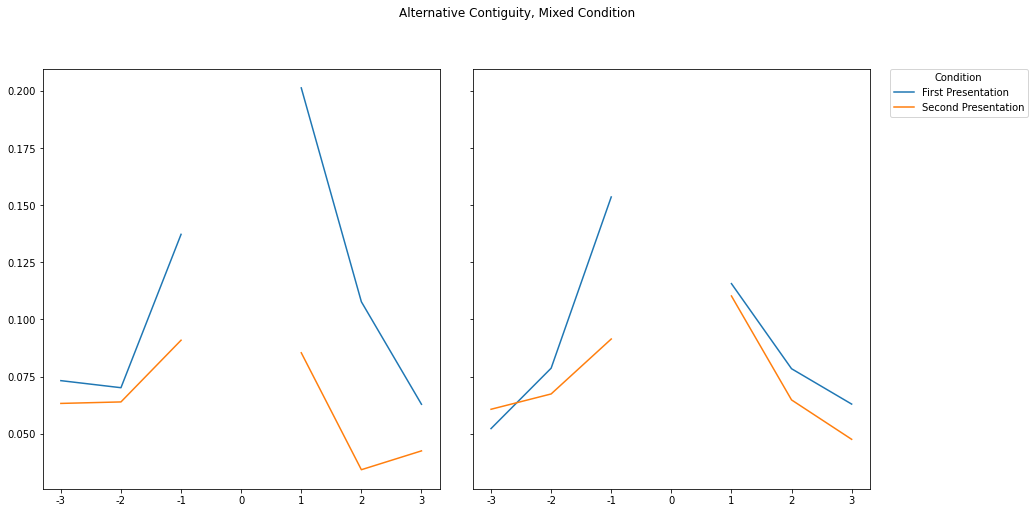

In [16]:
condition = 3
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 15/2), sharey=True)

test_altcrp= alternative_contiguity(
    trials[list_types==condition+1], presentations[list_types==condition+1], 6, 2)
test_altcrp[:, list_length-1] = np.nan
axes[0].plot(np.arange(7), test_altcrp[0][list_length-1-3:list_length-1+4], label='First Presentation')
axes[0].plot(np.arange(7), test_altcrp[1][list_length-1-3:list_length-1+4], label='Second Presentation')
axes[0].set_xticks(np.arange(7))
axes[0].set_xticklabels(np.arange(7) -3) 

sim_altcrp = alternative_contiguity(
    sim_trials[condition], sim_presentations[condition], 6, 2)
sim_altcrp[:, list_length-1] = np.nan
axes[1].plot(np.arange(7), sim_altcrp[0][list_length-1-3:list_length-1+4], label='First Presentation')
axes[1].plot(np.arange(7), sim_altcrp[1][list_length-1-3:list_length-1+4], label='Second Presentation')
axes[1].set_xticks(np.arange(7))
axes[1].set_xticklabels(np.arange(7) -3)

axes[1].legend(title='Condition', bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
fig.suptitle('Alternative Contiguity, ' + conditions[condition] + ' Condition')
plt.tight_layout(pad=3)
#plt.xlabel('Lag')
#plt.ylabel('Conditional Response Probability') `  

### Fit to Spacing Effect

In [27]:
# cost function to be minimized
# ours scales inversely with the probability that the data could have been 
# generated using the specified parameters and our model

selection = list_types == 4
cost_function = lohnas_mse_objective_function(
    trials[selection], 
    presentations[selection],
    (fast_rpl, ), 
    init_cmr,
    {'delay_drift_rate':0, 'sampling_rule': 0, 'mfc_familiarity_scale': 0, 'drift_familiarity_scale': 0, 'mcf_familiarity_scale': 0}, 
    cmr_free_parameters)

cmr_result = differential_evolution(cost_function, cmr_bounds, disp=True, atol=.001)

C:\ProgramData\Miniconda3\lib\site-packages\numba\core\utils.py:544: NumbaExperimentalFeatureWarning: First-class function type feature is experimental
  warnings.warn("First-class function type feature is experimental",


differential_evolution step 1: f(x)= 0.0444259
differential_evolution step 2: f(x)= 0.0133843
differential_evolution step 3: f(x)= 0.012045
differential_evolution step 4: f(x)= 0.012045
differential_evolution step 5: f(x)= 0.00545723
differential_evolution step 6: f(x)= 0.00473103
differential_evolution step 7: f(x)= 0.00257982
differential_evolution step 8: f(x)= 0.00257982
differential_evolution step 9: f(x)= 0.00257982
differential_evolution step 10: f(x)= 0.00257982
differential_evolution step 11: f(x)= 0.00257982
differential_evolution step 12: f(x)= 0.00201231
differential_evolution step 13: f(x)= 0.00201231
differential_evolution step 14: f(x)= 0.00155401
differential_evolution step 15: f(x)= 0.00155401
differential_evolution step 16: f(x)= 0.00155401
differential_evolution step 17: f(x)= 0.00155401
differential_evolution step 18: f(x)= 0.00155401
differential_evolution step 19: f(x)= 0.00146618
differential_evolution step 20: f(x)= 0.00125419
differential_evolution step 21: f(x

In [28]:
import numpy.matlib

experiment_count = 1000

sim_trials = ['dummy']*3
sim_presentations = ['dummy']*3
fitted_parameters = Dict.empty(
        key_type=types.unicode_type, value_type=types.float64)

i=3
for j in range(len(cmr_result.x)):
    fitted_parameters[cmr_free_parameters[j]] = cmr_result.x[j]
    
fitted_parameters['sampling_rule'] = 0
fitted_parameters['mfc_familiarity_scale'] = 0
fitted_parameters['mcf_familiarity_scale'] = 0
fitted_parameters['drift_familiarity_scale'] = 0
fitted_parameters['delay_drift_rate'] = 0

sim_trials.append(simulate_array_from_presentations(
    init_cmr, fitted_parameters, presentations[list_types==i+1], experiment_count))
sim_presentations.append(np.matlib.repmat(presentations[list_types==i+1], experiment_count, 1))

In [29]:
import pandas as pd

def rpl(presentations, trials, subjects, trial_count, list_length, max_lag=8):
    #subjects = len(np.unique(events.subject))
    #trial_count = np.max(events.list)
    #list_length = np.max(events.input)
    #lags = ['N/A'] + list(range(max_lag+1))
    lags = ['N/A', '0', '1-2', '3-5', '6-8']
    
    result = {'subject': [], 'lag': [], 'prob': []}
    
    for subject in range(subjects):

        subject_result = fast_rpl(
            trials[subject*trial_count:(subject+1)*trial_count], presentations[subject*trial_count:(subject+1)*trial_count], max_lag)
        
        binned = np.zeros(5)
        binned[0] = subject_result[0]
        binned[1] = subject_result[1]
        binned[2] = (subject_result[2] + subject_result[3])/2
        binned[3] = (subject_result[4] + subject_result[5] + subject_result[6])/3
        binned[4] = (subject_result[7] + subject_result[8] + subject_result[9])/3

        result['subject'] += [subject+1]*len(lags)
        result['lag'] += lags
        result['prob'] += binned.tolist()
        
    return pd.DataFrame(result)

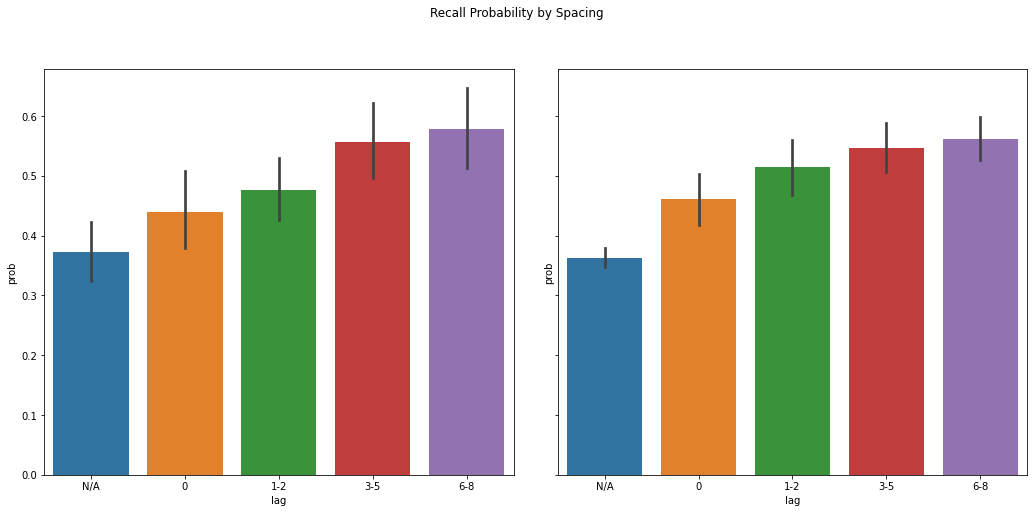

In [30]:
import seaborn as sns

condition = 4
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 15/2), sharey=True)

subject_count = len(np.unique(events.subject))
trial_count = int(np.max(events.list)/4)

data = rpl(
    presentations[list_types==condition], trials[list_types==condition], 
    subject_count, trial_count, list_length)

sns.barplot(ax=axes[0], data=data, x='lag', y='prob')

sim_data = rpl(
    sim_presentations[3], sim_trials[3],
    subject_count, trial_count, list_length)

sns.barplot(ax=axes[1], data=sim_data, x='lag', y='prob')
    
fig.suptitle("Recall Probability by Spacing")
plt.tight_layout(pad=3)

### Alternative Contiguity Omnibus

In [ ]:
# cost function to be minimized
# ours scales inversely with the probability that the data could have been 
# generated using the specified parameters and our model
@njit(nogil=True)
def init_cmr(item_count, presentation_count, parameters):
    return Classic_CMR(item_count, presentation_count, parameters)

selection = list_types == 4
cost_function = lohnas_objective_function(
    trials[selection], 
    presentations[selection],
    (flex_mixed_spc, flex_mixed_crp, alternative_contiguity), 
    init_cmr,
    {'delay_drift_rate':0, 'sampling_rule': 0, 'mfc_familiarity_scale': 0, 'drift_familiarity_scale': 0, 'mcf_familiarity_scale': 0}, 
    cmr_free_parameters)

cmr_result = differential_evolution(cost_function, cmr_bounds, disp=True)

In [ ]:
experiment_count = 1000

sim_trials = ['dummy']*3
sim_presentations = ['dummy']*3
fitted_parameters = Dict.empty(
        key_type=types.unicode_type, value_type=types.float64)

i=3
for j in range(len(cmr_result.x)):
    fitted_parameters[cmr_free_parameters[j]] = cmr_result.x[j]
    
fitted_parameters['sampling_rule'] = 0
fitted_parameters['mfc_familiarity_scale'] = 0
fitted_parameters['mcf_familiarity_scale'] = 0
fitted_parameters['drift_familiarity_scale'] = 0
fitted_parameters['delay_drift_rate'] = 0

sim_trials.append(simulate_array_from_presentations(
    init_cmr, fitted_parameters, presentations[list_types==i+1], experiment_count))
sim_presentations.append(np.matlib.repmat(presentations[list_types==i+1], experiment_count, 1))

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 15/2), sharey=True)

for condition in [3]:
    
    test_spc= flex_mixed_spc(trials[list_types==condition+1], presentations[list_types==condition+1])
    axes[0].plot(np.arange(len(test_spc)), test_spc, label=conditions[condition])

    sim_spc = flex_mixed_spc(sim_trials[condition], sim_presentations[condition])
    axes[1].plot(np.arange(len(sim_spc)), sim_spc, label=conditions[condition])

#axes[0].set(xlabel='Presentation Position', ylabel='Recall Rate') 
#axes[1].set(xlabel='Presentation Position', ylabel='Recall Rate') 
fig.suptitle("Serial Position Curve")
axes[1].legend(title='Condition', bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.tight_layout(pad=3)

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 15/2), sharey=True)

for condition in [3]:

    test_crp= flex_mixed_crp(trials[list_types==condition+1], presentations[list_types==condition+1])
    test_crp[len(presentations[0])-1] = np.nan
    axes[0].plot(np.arange(len(test_crp)), test_crp, label=conditions[condition])

    sim_crp = flex_mixed_crp(sim_trials[condition], sim_presentations[condition])
    sim_crp[len(presentations[0])-1] = np.nan
    axes[1].plot(np.arange(len(sim_crp)), sim_crp, label=conditions[condition])

#plt.xlabel('Lag')
#plt.ylabel('Conditional Response Probability')   
axes[0].set_xticks(np.arange(0, len(test_crp), 4))
axes[0].set_xticklabels(np.arange(0, len(test_crp), 4) - 39)
axes[1].set_xticks(np.arange(0, len(sim_crp), 4))
axes[1].set_xticklabels(np.arange(0, len(sim_crp), 4) - 39)
fig.suptitle('Lag-CRP')
axes[1].legend(title='Condition', bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.tight_layout(pad=3)

In [ ]:
condition = 3
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 15/2), sharey=True)

test_altcrp= alternative_contiguity(
    trials[list_types==condition+1], presentations[list_types==condition+1], 6, 2)
test_altcrp[:, list_length-1] = np.nan
axes[0].plot(np.arange(7), test_altcrp[0][list_length-1-3:list_length-1+4], label='First Presentation')
axes[0].plot(np.arange(7), test_altcrp[1][list_length-1-3:list_length-1+4], label='Second Presentation')
axes[0].set_xticks(np.arange(7))
axes[0].set_xticklabels(np.arange(7) -3) 

sim_altcrp = alternative_contiguity(
    sim_trials[condition], sim_presentations[condition], 6, 2)
sim_altcrp[:, list_length-1] = np.nan
axes[1].plot(np.arange(7), sim_altcrp[0][list_length-1-3:list_length-1+4], label='First Presentation')
axes[1].plot(np.arange(7), sim_altcrp[1][list_length-1-3:list_length-1+4], label='Second Presentation')
axes[1].set_xticks(np.arange(7))
axes[1].set_xticklabels(np.arange(7) -3)

axes[1].legend(title='Condition', bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
fig.suptitle('Alternative Contiguity, ' + conditions[condition] + ' Condition')
plt.tight_layout(pad=3)
#plt.xlabel('Lag')
#plt.ylabel('Conditional Response Probability') `  

### Spacing Omnibus

In [ ]:
# cost function to be minimized
# ours scales inversely with the probability that the data could have been 
# generated using the specified parameters and our model
@njit(nogil=True)
def init_cmr(item_count, presentation_count, parameters):
    return Classic_CMR(item_count, presentation_count, parameters)

selection = list_types == 4
cost_function = lohnas_objective_function(
    trials[selection], 
    presentations[selection],
    (flex_mixed_spc, flex_mixed_crp, fast_rpl), 
    init_cmr,
    {'delay_drift_rate':0, 'sampling_rule': 0, 'mfc_familiarity_scale': 0, 'drift_familiarity_scale': 0, 'mcf_familiarity_scale': 0}, 
    cmr_free_parameters)

cmr_result = differential_evolution(cost_function, cmr_bounds, disp=True)

In [ ]:
experiment_count = 1000

sim_trials = ['dummy']*3
sim_presentations = ['dummy']*3
fitted_parameters = Dict.empty(
        key_type=types.unicode_type, value_type=types.float64)

i=3
for j in range(len(cmr_result.x)):
    fitted_parameters[cmr_free_parameters[j]] = cmr_result.x[j]
    
fitted_parameters['sampling_rule'] = 0
fitted_parameters['mfc_familiarity_scale'] = 0
fitted_parameters['mcf_familiarity_scale'] = 0
fitted_parameters['drift_familiarity_scale'] = 0
fitted_parameters['delay_drift_rate'] = 0

sim_trials.append(simulate_array_from_presentations(
    init_cmr, fitted_parameters, presentations[list_types==i+1], experiment_count))
sim_presentations.append(np.matlib.repmat(presentations[list_types==i+1], experiment_count, 1))

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 15/2), sharey=True)

for condition in [3]:
    
    test_spc= flex_mixed_spc(trials[list_types==condition+1], presentations[list_types==condition+1])
    axes[0].plot(np.arange(len(test_spc)), test_spc, label=conditions[condition])

    sim_spc = flex_mixed_spc(sim_trials[condition], sim_presentations[condition])
    axes[1].plot(np.arange(len(sim_spc)), sim_spc, label=conditions[condition])

#axes[0].set(xlabel='Presentation Position', ylabel='Recall Rate') 
#axes[1].set(xlabel='Presentation Position', ylabel='Recall Rate') 
fig.suptitle("Serial Position Curve")
axes[1].legend(title='Condition', bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.tight_layout(pad=3)

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 15/2), sharey=True)

for condition in [3]:

    test_crp= flex_mixed_crp(trials[list_types==condition+1], presentations[list_types==condition+1])
    test_crp[len(presentations[0])-1] = np.nan
    axes[0].plot(np.arange(len(test_crp)), test_crp, label=conditions[condition])

    sim_crp = flex_mixed_crp(sim_trials[condition], sim_presentations[condition])
    sim_crp[len(presentations[0])-1] = np.nan
    axes[1].plot(np.arange(len(sim_crp)), sim_crp, label=conditions[condition])

#plt.xlabel('Lag')
#plt.ylabel('Conditional Response Probability')   
axes[0].set_xticks(np.arange(0, len(test_crp), 4))
axes[0].set_xticklabels(np.arange(0, len(test_crp), 4) - 39)
axes[1].set_xticks(np.arange(0, len(sim_crp), 4))
axes[1].set_xticklabels(np.arange(0, len(sim_crp), 4) - 39)
fig.suptitle('Lag-CRP')
axes[1].legend(title='Condition', bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.tight_layout(pad=3)

In [ ]:
import seaborn as sns

condition = 4
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 15/2), sharey=True)

subject_count = len(np.unique(events.subject))
trial_count = int(np.max(events.list)/4)

data = rpl(
    presentations[list_types==condition], trials[list_types==condition], 
    subject_count, trial_count, list_length)

sns.barplot(ax=axes[0], data=data, x='lag', y='prob')

sim_data = rpl(
    sim_presentations[3], sim_trials[3],
    subject_count, trial_count, list_length)

sns.barplot(ax=axes[1], data=sim_data, x='lag', y='prob')
    
fig.suptitle("Recall Probability by Spacing")
plt.tight_layout(pad=3)

### Omnibus

In [ ]:
# cost function to be minimized
# ours scales inversely with the probability that the data could have been 
# generated using the specified parameters and our model
@njit(nogil=True)
def init_cmr(item_count, presentation_count, parameters):
    return Classic_CMR(item_count, presentation_count, parameters)

selection = list_types == 4
cost_function = lohnas_objective_function(
    trials[selection], 
    presentations[selection],
    (flex_mixed_spc, flex_mixed_crp, alternative_contiguity, fast_rpl), 
    init_cmr,
    {'delay_drift_rate':0, 'sampling_rule': 0, 'mfc_familiarity_scale': 0, 'drift_familiarity_scale': 0, 'mcf_familiarity_scale': 0}, 
    cmr_free_parameters)

cmr_result = differential_evolution(cost_function, cmr_bounds, disp=True)

In [ ]:
experiment_count = 1000

sim_trials = ['dummy']*3
sim_presentations = ['dummy']*3
fitted_parameters = Dict.empty(
        key_type=types.unicode_type, value_type=types.float64)

i=3
for j in range(len(cmr_result.x)):
    fitted_parameters[cmr_free_parameters[j]] = cmr_result.x[j]
    
fitted_parameters['sampling_rule'] = 0
fitted_parameters['mfc_familiarity_scale'] = 0
fitted_parameters['mcf_familiarity_scale'] = 0
fitted_parameters['drift_familiarity_scale'] = 0
fitted_parameters['delay_drift_rate'] = 0

sim_trials.append(simulate_array_from_presentations(
    init_cmr, fitted_parameters, presentations[list_types==i+1], experiment_count))
sim_presentations.append(np.matlib.repmat(presentations[list_types==i+1], experiment_count, 1))

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 15/2), sharey=True)

for condition in [3]:
    
    test_spc= flex_mixed_spc(trials[list_types==condition+1], presentations[list_types==condition+1])
    axes[0].plot(np.arange(len(test_spc)), test_spc, label=conditions[condition])

    sim_spc = flex_mixed_spc(sim_trials[condition], sim_presentations[condition])
    axes[1].plot(np.arange(len(sim_spc)), sim_spc, label=conditions[condition])

#axes[0].set(xlabel='Presentation Position', ylabel='Recall Rate') 
#axes[1].set(xlabel='Presentation Position', ylabel='Recall Rate') 
fig.suptitle("Serial Position Curve")
axes[1].legend(title='Condition', bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.tight_layout(pad=3)

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 15/2), sharey=True)

for condition in [3]:

    test_crp= flex_mixed_crp(trials[list_types==condition+1], presentations[list_types==condition+1])
    test_crp[len(presentations[0])-1] = np.nan
    axes[0].plot(np.arange(len(test_crp)), test_crp, label=conditions[condition])

    sim_crp = flex_mixed_crp(sim_trials[condition], sim_presentations[condition])
    sim_crp[len(presentations[0])-1] = np.nan
    axes[1].plot(np.arange(len(sim_crp)), sim_crp, label=conditions[condition])

#plt.xlabel('Lag')
#plt.ylabel('Conditional Response Probability')   
axes[0].set_xticks(np.arange(0, len(test_crp), 4))
axes[0].set_xticklabels(np.arange(0, len(test_crp), 4) - 39)
axes[1].set_xticks(np.arange(0, len(sim_crp), 4))
axes[1].set_xticklabels(np.arange(0, len(sim_crp), 4) - 39)
fig.suptitle('Lag-CRP')
axes[1].legend(title='Condition', bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.tight_layout(pad=3)

In [ ]:
condition = 3
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 15/2), sharey=True)

test_altcrp= alternative_contiguity(
    trials[list_types==condition+1], presentations[list_types==condition+1], 6, 2)
test_altcrp[:, list_length-1] = np.nan
axes[0].plot(np.arange(7), test_altcrp[0][list_length-1-3:list_length-1+4], label='First Presentation')
axes[0].plot(np.arange(7), test_altcrp[1][list_length-1-3:list_length-1+4], label='Second Presentation')
axes[0].set_xticks(np.arange(7))
axes[0].set_xticklabels(np.arange(7) -3) 

sim_altcrp = alternative_contiguity(
    sim_trials[condition], sim_presentations[condition], 6, 2)
sim_altcrp[:, list_length-1] = np.nan
axes[1].plot(np.arange(7), sim_altcrp[0][list_length-1-3:list_length-1+4], label='First Presentation')
axes[1].plot(np.arange(7), sim_altcrp[1][list_length-1-3:list_length-1+4], label='Second Presentation')
axes[1].set_xticks(np.arange(7))
axes[1].set_xticklabels(np.arange(7) -3)

axes[1].legend(title='Condition', bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
fig.suptitle('Alternative Contiguity, ' + conditions[condition] + ' Condition')
plt.tight_layout(pad=3)
#plt.xlabel('Lag')
#plt.ylabel('Conditional Response Probability') `  

In [ ]:
import seaborn as sns

condition = 4
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 15/2), sharey=True)

subject_count = len(np.unique(events.subject))
trial_count = int(np.max(events.list)/4)

data = rpl(
    presentations[list_types==condition], trials[list_types==condition], 
    subject_count, trial_count, list_length)

sns.barplot(ax=axes[0], data=data, x='lag', y='prob')

sim_data = rpl(
    sim_presentations[3], sim_trials[3],
    subject_count, trial_count, list_length)

sns.barplot(ax=axes[1], data=sim_data, x='lag', y='prob')
    
fig.suptitle("Recall Probability by Spacing")
plt.tight_layout(pad=3)